## Gil Zeevi 203909320
## Liv Abravaya 205644313

##  <span style="color:blue">Exercise 3 - Driver file </span>
## <span style="color:blue">Computer Vision - Fall 2020


**Lecturer:** Prof. Yael Moses, IDC

**TA:** Eyal Friedman, IDC

**Sybmission date: 11.1.2021**



In this exercise you will practice working with videos, and simple segmentations.

## Submission guidelines:

1. Your zip file should include the following files only:
    - ex2-driver.ipynb  **Or**  ex2-driver.py 
    - ex2_ID_ID.doc  **Or**  ex2_ID_ID.pdf
2. The results you are asked to display and the open questions should be answered in a doc/pdf file. 
   (Don't add the python code to that file.)
4. You may use any IDE  (e.g., Spyder, Jupyter Notebook, Pycharm, ect.).
5. Name the file 'ex2_ID_ID.zip' and do **not** include any additional directories. 
6. Submit using *moodle*
7. Submit on time!
8. You can submit this assignment in pairs (no triples).

## Read the following instructions carefully:
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Do not submit your tests, unless requested.
3. Use `python 3` and `numpy 1.18.5`. Changes of the configuration we provided are at your own risk. Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works.
4. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden, unless been provided by us.
4. Your code must run without errors. Note,  **code that fails to  run will not be graded.**
5. Document your code properly.
6. **Note:** you are given a set of videos, you are welcome to use them or any other videos. If they are too long, you can use only part of the frames. If they are too large, you can rescale them.
7. In case there  are several possible variations for implementing the algorithms - make your own  choice, and give a short explanation.

## Honor Code:
The assignment is a basic tool for learning the material. You can probably find the solution on the Web. However, if  you do so, then you will not learn what you should learn from it. In addition, since we  grade  the assignment, using existing solutions will be considered dishonest.
In particular, you are not allowed to copy or use any code that solves the task. 
You are more than welcome to talk with your friends, but you are not allowed to give your code or answers and you are not allowed to use their code or answers. 
Remember – you take this course in order to learn.


In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import null_space
from tqdm import tqdm_notebook as tqdm
from scipy.signal import convolve2d

In [2]:
import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)
import warnings
warnings.filterwarnings("ignore")

Python version:  3.8.3
Numpy version:  1.18.5


## Section A: Change Detection

**A1. Simple change detection**

Compute a simple change detection algorithm. Use as background the median of a set of k1 frames, and update it every k2 frames. Your algorithm should work on color images. Think how to merge the different channels (colors). You can assume that the camera is static. The output is a video where the pixels of the  foreground objects consists of the original frame, and the other pixels are black. 

*Input:* name_file, k1, k2, and any other parameter you would like to add\
name_file: a name of a video file\
k1: the number of frames for computing the median\
k2: the number of frames between two updates of the background

*output:*  v_foreground

In [3]:
def median_change_dection(name_file, k1, k2):
    cap = cv2.VideoCapture(name_file)
    ret, frame = cap.read()
    v_foreground = []
    k1_arr=np.zeros((k1,frame.shape[0],frame.shape[1],frame.shape[2]))
    counter_k1, counter_k2, th= 0 , 0, 0.15
    update=[]
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            if counter_k1!=k1 or counter_k1==0:
                k1_arr[counter_k1]=frame.copy()
            else:   
                med_frame=np.median(k1_arr,axis=0)
                counter_k1=0
            if counter_k2%k2==0 and counter_k2>0:
                update=med_frame.copy()
            elif counter_k2<k2:
                update=frame.copy()
            L,H=update*(1-th),update*(1+th)
            log0=np.logical_and(frame[:,:,0]>=L[:,:,0],frame[:,:,0]<H[:,:,0])
            log1=np.logical_and(frame[:,:,1]>=L[:,:,1],frame[:,:,1]<H[:,:,1])
            log2=np.logical_and(frame[:,:,2]>=L[:,:,2],frame[:,:,2]<H[:,:,2])
            x,y=np.where(log0|log1|log2)
            frame[x,y,:]=0
            counter_k1+=1 ;counter_k2+=1
            v_foreground.append(frame.copy())
            cv2.imshow('frame', frame)
            cv2.waitKey(25)
        else:
            break
    cap.release()
    cv2.destroyAllWindows()
    return np.array(v_foreground)

In [4]:
v_foreground=median_change_dection('SLIDE.avi', 10, 20)

In [5]:
def save_output(v_foreground: np.ndarray, out_filename_video: str):
    y = v_foreground.shape[2]
    x = v_foreground.shape[1]

    out = cv2.VideoWriter(out_filename_video, cv2.VideoWriter_fourcc(*"MJPG"), 30, (y, x))

    for i in range(len(v_foreground)):
        out.write(v_foreground[i].astype('uint8'))

    out.release()
save_output(v_foreground,'v_foreground.avi')

**A2. Post Processing for  change detection**

**Answer:** Suggest a post processing algorithm for improving  the results of a change detection algorithm (e.g., remove noise or fill gaps). 

**Code:** implement your algorithm.

*Input:*  v_original, v_foreground\
v_original: the original video\
v_foreground: the output of B1

*output:* v_PP_foreground\
v_PP_foreground: the result of the post processing on v_foreground.


**Note:**
1. You may want to generate from v_foreground  a binary mask of the foreground regions.
2. You can use dilation or erosion on a the binary mask.
3.  You may use additional frames to improve the results, but you do not have to.


# Our algorithm of improving resulted video:
*1. we used of course a boolean mask - as suggested.*

*2. we used cv2.morphologyEx(bool_mask,cv2.MORPH_OPEN,kernel) - Opening operation in cvs2 just activates erosion followed by dilation on the boolean mask. It is useful in removing noise. we've done some manual iteration to get a decent resulting kernel*

*3. we used cv2.morphologyEx(bool_mask,cv2.MORPH_CLOSE,kernel) - closing operation in cv2 is the opposite to Opening. it activates dilation followed by erosion on the boolean mask. It is useful in closing small holes inside the foreground objects. we've done some manual iteration to get a decent resulting kernel*

*4. in the end, we dilated the final mask in order to enlarge the foreground to get a clearer foreground*


In [6]:
def improve_foreground(v_original,v_foreground,k_size=15):
    cap_org = cv2.VideoCapture(v_original)
    cap_for = cv2.VideoCapture(v_foreground)
    v_PP_foreground = []
    while cap_org.isOpened() and cap_for.isOpened():
        ret, frame_org = cap_org.read()
        ret2, frame_for = cap_for.read()
        if ret and ret2:
            mask = np.any(frame_for, axis=2).astype(dtype=np.uint8)
            mask=cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((k_size,k_size)))
            mask=cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((k_size,k_size)))
            mask=cv2.dilate(mask,np.ones((k_size,k_size))) 
            frame_org[mask==0]=0
            cv2.imshow('v_PP_foreground', frame_org)
            cv2.waitKey(30)
            #here we decided to resize the original video to get things going on faster
            scale_percent = 60 # percent of original size
            width = int(frame_org.shape[1] * scale_percent / 100)
            height = int(frame_org.shape[0] * scale_percent / 100)
            dim = (width, height)
            # resize image
            resized = cv2.resize(frame_org, dim, interpolation = cv2.INTER_AREA)
            v_PP_foreground.append(resized)
        else:
            break
    cap_for.release()
    cap_org.release()
    cv2.destroyAllWindows()
    return np.array(v_PP_foreground)

In [7]:
v_PP_foreground = improve_foreground('SLIDE.avi','v_foreground.avi',17)

In [8]:
save_output(v_PP_foreground,'v_PP_foreground.avi')

**A3. Counting  foreground objects**

Write a function that counts the number of foreground objects in the result of A1 or A2. 

*Input:* v_foreground\
v_foreground: a video which is the output of B1 or B2

*Output*: c\
c: a vector with the number of foreground objects in each of the frames

**Note:** You can use a function that counts connected components in a binary image.


In [9]:
def count_foreground_objects(v_foreground):
    cap = cv2.VideoCapture(v_foreground)
    cc_vec=[]
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            mask = np.any(frame, axis=2).astype(dtype=np.uint8)
            kernel = np.ones((10,10), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) # used closing (dilation followed by erosion) to improve results
            ret, labels = cv2.connectedComponents(mask, connectivity=8)
            frame[mask==0]=0
            cc_vec.append(ret-1)

        else:
            break
    cap.release()
    return np.array(cc_vec)

In [10]:
count_foreground_objects('v_PP_foreground.avi') #applying on the A2 result

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  7,  6,  7,  6,  6,  7,  7,  8,  9,  6,  7,  7,  6,  8,
        7,  7,  6,  7,  6,  5,  6,  9,  7,  9,  7,  7,  6,  6,  6,  6,  6,
        5,  4,  6,  6,  7,  6,  6,  4,  4, 10,  6,  6,  8,  8,  6,  6,  6,
        5,  6,  5,  5,  6,  6,  6,  5,  4,  5,  5,  5,  8,  7,  7,  8,  7,
        5,  5,  6,  6,  7,  7,  6,  6,  4,  3,  6,  4,  4,  5,  6,  4,  6,
        7,  5,  5,  6,  8,  9])

### **Note:** 
We are expecting to get the 20th first objects as 0 because we chose k2 = 20.
the way we implemented A1, we started to apply threshold before it is updated to include the median of k1 frames, so before the frames get to k2 and the background is updated, our algorithm assign 0 to each pixel thus the first 20 (k2 is 20) objects are 0.

## Section B: Compute Optical Flow (OF) using Lucas-Kanade

**B1. Basic Lucas Kanade OF**

Impelment the basic Lucas-Kanade we leared in class.

*Input:*  name_file, nf1, nf2,  sigma_R, sigma_S\
name_file: a name of a video file\
f1 and f2: the numbers of the two frames form the video on which the OF is computed.\
sigma_S: the variance of the Gaussian used for the  spatial smoothing  as in HW1 (for computing the derivative of a Gaussian).\
sigma_R: the variance of the Gaussian for computing the sum of the derivatives (the convolution replace the sum).

*Output:* U, V, im1,im2\
U, V:  two matrices with the x and y motion for each pixel, respectively.\
im1, im2: the frames on which the optical flow was computed (their number in the video is nf1 and nf2).

**Note:**
1. You can use any video reading method you find convenient.
2. Do not forget to convert the images into grey scale.
3. You can compute the derivatives of the images as in HW1 - convolution with the derivative of a Gaussian.
3. You can resize the images in order for the program to run faster.
5. The computed OF is not necessarily integers. You may want to perform float computation.
6. For sigma_R look at slide 63 of Class 7.

In [11]:
# functions from HW1:
def mat_base(sigma):
    mask_size = sigma * 4
    if type(sigma) != int:
        mask_size = int(np.ceil(mask_size))
    # in order to get 95% signal we have to use 2 standard deviations from each side of the gauss bell
    if (mask_size % 2) == 0:  # check if the size is even
        mask_size += 1  # if it does -> make odd. by +1 we maintain 95% of the signal
    ax = np.linspace(-mask_size // 2, mask_size // 2, mask_size)
    [xx, yy] = np.meshgrid(ax,ax)  # Assign two matrices with the appropriate x and y values on which the gaussian function is computed
    return xx, yy

def kernel_Gauss(sigma):
    [x, y] = mat_base(sigma)
    G_dx = (1 / (2 * np.pi * sigma ** 2)) * np.exp(-(np.square(x) + np.square(y)) / (2 * sigma ** 2))
    return G_dx / G_dx.sum()


def Deriv_Gauss_x(sigma):
    [x, y] = mat_base(sigma)
    G_dx = (-x / (2 * np.pi * sigma ** 4)) * np.exp(-(np.square(x) + np.square(y)) / (2 * sigma ** 2))
    return G_dx / G_dx.sum()


def Deriv_Gauss_y(sigma):
    [x, y] = mat_base(sigma)
    G_dy = (-y / (2 * np.pi * sigma ** 4)) * np.exp(-(np.square(x) + np.square(y)) / (2 * sigma ** 2))
    return G_dy / G_dy.sum()



def Grad_m(Ix, Iy):
    grad = (Ix ** 2 + Iy ** 2) ** 0.5
#     grad *= 255.0 / grad.max()
    return grad

def Grad_x(img, G_dx):
    resultConv = convolve2d(img, G_dx, mode='same')
    return resultConv


def Grad_y(img, G_dy):
    resultConv = convolve2d(img, G_dy, mode='same')
    return resultConv

In [12]:
#helping functions:

def gauss_blur(I,sig_s): #apply gaussian blur
    ix = Deriv_Gauss_x(sig_s)
    iy = Deriv_Gauss_y(sig_s)
    gx = Grad_x(I , ix)
    gy = Grad_x(I , iy)
    G = Grad_m(gx,gy)
    return G

def win_from_sig(sigma): # derive a window from given sigma - as used in hw1
    mask_size = sigma * 4
    if type(sigma) != int:
        mask_size = int(np.ceil(mask_size))
    # in order to get 95% signal we have to use 2 standard deviations from each side of the gauss bell
    if (mask_size % 2) == 0:  # check if the size is even
        mask_size += 1  # if it does -> make odd. by +1 we maintain 95% of the signal
    return mask_size

def get_two_frames(name_file,nf1,nf2): # returns two  grayscale frames from video - frame nf1 and frame nf2
    frst = nf1 if nf1 < nf2 else nf2
    scnd = nf1 if nf1 > nf2 else nf2
    counter = 0
    cap = cv2.VideoCapture(name_file)
    cc_vec = []
    while cap.isOpened():
        counter+=1
        ret, frame = cap.read()
        if ret:
            if counter == frst:
                I_1 = frame.copy()
                # here we decided to resize the original frame to get things going on faster
                scale_percent = 60  # percent of original size
                width = int(I_1.shape[1] * scale_percent / 100)
                height = int(I_1.shape[0] * scale_percent / 100)
                dim = (width, height)
                # resize image
                I_1 = cv2.resize(I_1, dim, interpolation=cv2.INTER_AREA)
            if counter == scnd:
                I_2 = frame.copy()
                # here we decided to resize the original frame to get things going on faster
                scale_percent = 60  # percent of original size
                width = int(I_2.shape[1] * scale_percent / 100)
                height = int(I_2.shape[0] * scale_percent / 100)
                dim = (width, height)
                # resize image
                I_2 = cv2.resize(I_2, dim, interpolation=cv2.INTER_AREA)
                break
        else:
            break
    cap.release()
    return cv2.cvtColor(I_1, cv2.COLOR_BGR2GRAY) , cv2.cvtColor(I_2, cv2.COLOR_BGR2GRAY)

In [13]:
def basic_LK_OF(name_file, nf1, nf2, sigma_S, sigma_R,w=0):
    I1, I2 = get_two_frames(name_file,nf1,nf2)
    ix_s = Deriv_Gauss_x(sigma_S) ; iy_s = Deriv_Gauss_y(sigma_S)
    kern_r = kernel_Gauss(sigma_R)
    fx_1 = convolve2d(I1, ix_s, mode='same'); fy_1 = convolve2d(I1, iy_s, mode='same')
    # now building smoothed IT
    IT = convolve2d(I2, kernel_Gauss(sigma_S), mode='same') - convolve2d(I1, kernel_Gauss(sigma_S), mode='same')
    if w==0:
        w = win_from_sig(sigma_R)  #deciding on a window for LK 
    p = w //2
    C1= convolve2d(fx_1**2, kern_r, mode='same')
    C2= convolve2d(fy_1**2, kern_r, mode='same')
    C_12= convolve2d(fx_1*fy_1, kern_r, mode='same')
    u = np.zeros(I1.shape)
    v = np.zeros(I1.shape)
    for i in tqdm(range(p, I1.shape[0] - p)):
        for j in range(p, I1.shape[1] - p):
            Ix = fx_1[i - p:i + p + 1, j - p:j + p + 1].flatten()
            Iy = fy_1[i - p:i + p + 1, j - p:j + p + 1].flatten()
            It = IT[i - p:i + p + 1, j - p:j + p + 1].flatten()
            A = np.vstack((Ix, Iy)).T
            b = np.reshape(It, (It.shape[0],1)) * -1 #It vector has negative sign
            C = np.array([[C1[i,j],C_12[i,j]],[C_12[i,j],C2[i,j]]])
            if np.linalg.matrix_rank(C) == 2: # if the rank of c is 2 calculate velocity
                velocity = (np.linalg.pinv(A)) @ b
                u[i, j] = velocity [0]
                v[i, j] = velocity [1]
    return u,v,I1,I2

**B2. Present OF results**

*Input:* im1, U, V (the output of Basic_LK_OF without im2).

*Output:* a quiver plot overlaid the input  frame

**Note:**
1. You can look at https://pythonforundergradengineers.com/quiver-plot-with-matplotlib-and-jupyter-notebooks.html
2. You may want for visualaization to uniformally resize the values of U and V - if they are too large or too small/
2. You may not want to draw the OF  each pixel - to avoid OF overlapping of neighboring pixels.

In [14]:
def OF_plot_results(U,V,im1,scale = 0.25):
    plt.figure(figsize=(14, 10))
    nvec = 40 
    nl, nc = im1.shape
    step = max(nl//nvec, nc//nvec)
    y, x = np.mgrid[:nl:step, :nc:step]
    u_ = U[::step, ::step]
    v_ = V[::step, ::step]
    plt.imshow(im1,cmap = 'gray')
    plt.quiver(x, y, u_, -v_, color='coral',scale = scale)
    plt.tight_layout()


**B3. Evaluate OF results**

*Input:* im1, im2,  U, V (the output of Basic_LK_OF).

*Output:* w_im1, w_diff, err\
w_im1: the results of wrapping im1 using (U,V) toward im2 (matrix).\
w_diff:  |wraped_im1 -  im2| (matrix).\
err: the sum of square differences between w_im1 and im2 (scalar).

**Note:**\
 You can use any wrapping function you like from openCV or other code.


In [15]:
def  eval_OF(im1,im2,U,V):
    #building interpolated 2nd frame using cv2 remap
    x = np.arange(0, im1.shape[1])
    y = np.arange(0, im1.shape[0])
    xu, yv = np.meshgrid(x, y)
    x_map = (xu + U).astype(np.float32)
    y_map = (yv + V).astype(np.float32)
    w_im1 = cv2.remap(im1.astype(np.float32), x_map, y_map, cv2.INTER_LINEAR)
    w_diff = np.abs(w_im1.astype(np.float32) - im2.astype(np.float32))
    err = np.sum((w_im1.astype(np.float32) - im2.astype(np.float32))**2)
    return w_im1, w_diff, err

**B4. Affine_LK_OF**

Use the variant of Lucas-Kanade with affine motion instead of translation.
See slides - class 7 slides 73-75.

The input and output is the same as in **B1**.



In [16]:
def affine_LK_OF(video, nf1, nf2, sigma_S, sigma_R,w=0):
    I1, I2 = get_two_frames(video,nf1,nf2)
    ix_s = Deriv_Gauss_x(sigma_S) ; iy_s = Deriv_Gauss_y(sigma_S)
    kern_r = kernel_Gauss(sigma_R)
    fx_1 = convolve2d(I1, ix_s, mode='same'); fy_1 = convolve2d(I1, iy_s, mode='same')
    # now building smoothed IT
    IT = convolve2d(I2, kernel_Gauss(sigma_S), mode='same') - convolve2d(I1, kernel_Gauss(sigma_S), mode='same')
    if w==0:
        w = win_from_sig(sigma_R)  #deciding on a window for LK 
    p = w //2  
    u = np.zeros(I1.shape)
    v = np.zeros(I1.shape)
    x = np.arange(0, I1.shape[1])
    y = np.arange(0, I1.shape[0])
    xu, yv = np.meshgrid(x, y)

    
    for i in tqdm(range(p, I1.shape[0] - p)):
        for j in range(p, I1.shape[1] - p):
            Ix = fx_1[i - p:i + p + 1, j - p:j + p + 1].flatten()
            Iy = fy_1[i - p:i + p + 1, j - p:j + p + 1].flatten()
            It = IT[i - p:i + p + 1, j - p:j + p + 1].flatten()
            X = xu[i - p:i + p + 1, j - p:j + p + 1].flatten()
            Y = yv[i - p:i + p + 1, j - p:j + p + 1].flatten()
            B = np.vstack((Ix, X*Ix,Y*Ix,Iy, X*Iy,Y*Iy)).T
            b = np.reshape(It, (It.shape[0],1)) 
            C = B.T @ B
            if np.linalg.det(C) != 0: # if the det of C is not 0 - there is an inverse for B                
                velocity = (np.linalg.pinv(B)) @ b  * -1  #It vector has negative sign
                u[i, j] = velocity[0]+ velocity[1]*j + velocity[2]*i
                v[i, j] = velocity[3]+ velocity[4]*j + velocity[5]*i
    return u,v,I1,I2

### results

In [18]:
U, V, im1,im2 = basic_LK_OF('cars5.avi',12,14,1.5,5)

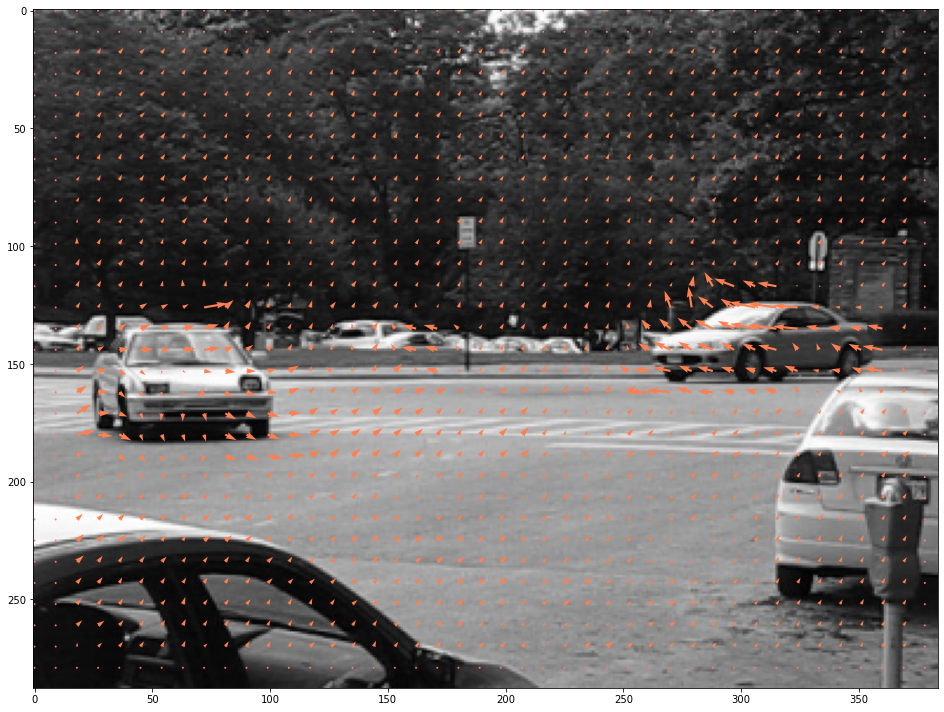

In [24]:
OF_plot_results(U.copy(),V.copy(),im1,1.4)

In [25]:
U, V, im1,im2 = affine_LK_OF('cars5.avi',12,14,1.5,5)

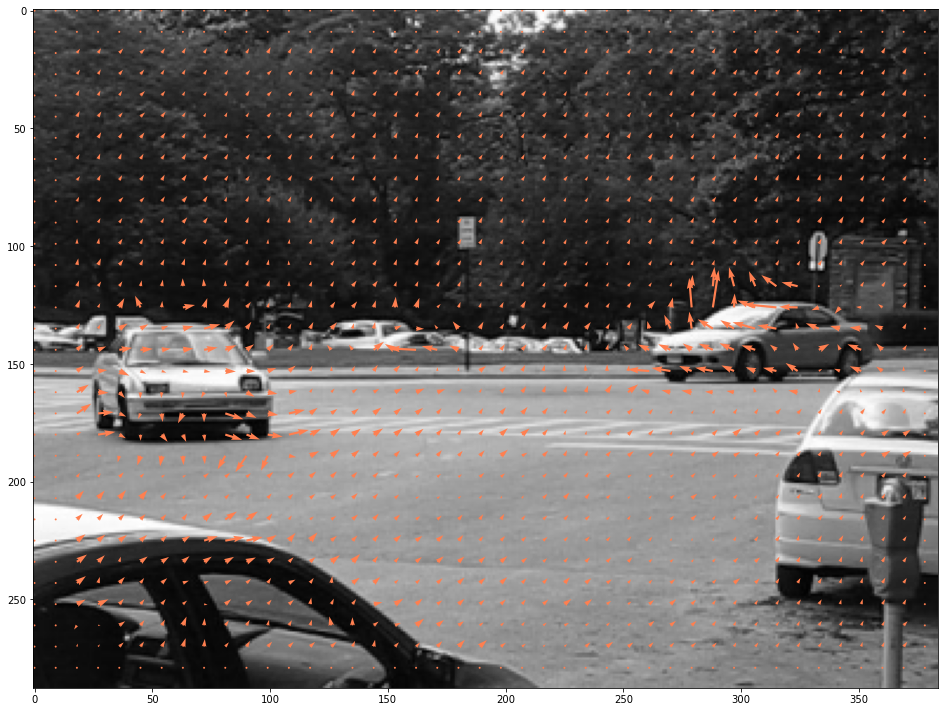

In [26]:
OF_plot_results(U.copy(),V.copy(),im1,1.4)

(<matplotlib.image.AxesImage at 0x1fe3232d550>, Text(0.5, 1.0, 'w_diff'))

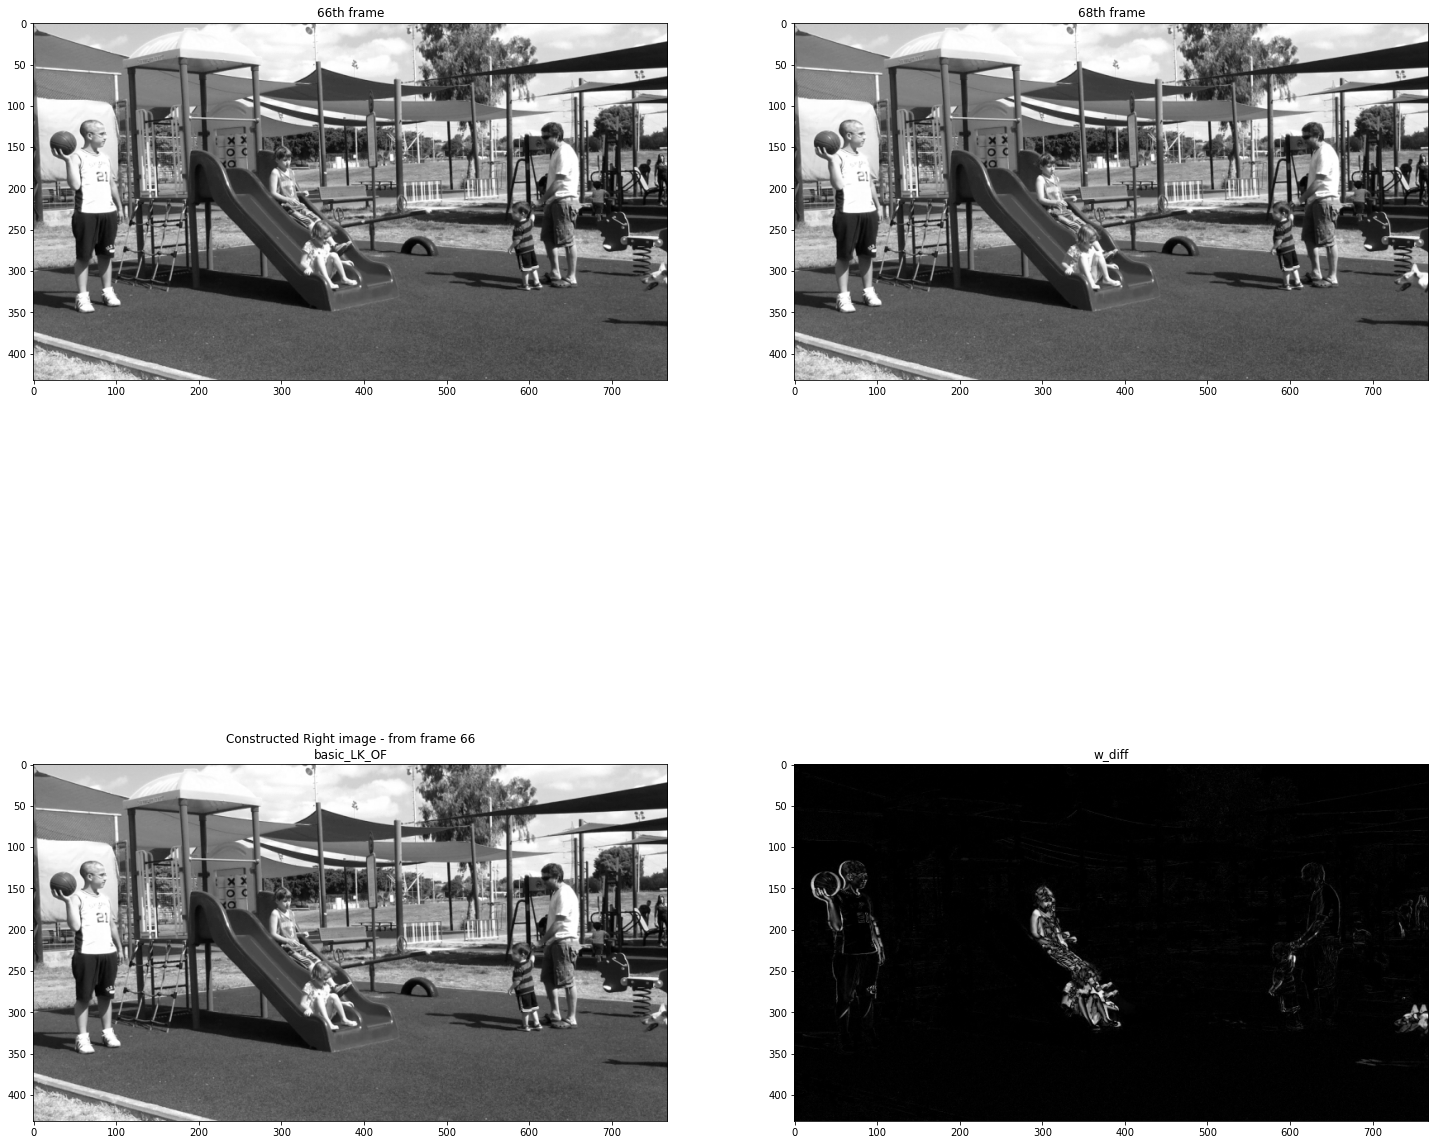

In [42]:
w_im1, w_diff, err = eval_OF(im1,im2,U,V)
plt.rcParams['figure.figsize'] = (25.0, 25.0) 
f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
ax1.imshow(im1, cmap='gray'), ax1.set_title('66th frame')
ax2.imshow(im2, cmap='gray'), ax2.set_title('68th frame')
ax3.imshow(w_im1, cmap='gray'), ax3.set_title('Constructed Right image - from frame 66\nbasic_LK_OF')
ax4.imshow(w_diff, cmap='gray'), ax4.set_title('w_diff')

**B5. Apply and Discuss:**

Run the basic_LK_OF, and the affine_LK_OF on one or two videos, one with a static camera and the other with a moving camera.
Play with the frames chosen from each video, the algorithm parameters, and  the distance between nf1 and nf2.

**Answer:**
1. The disparity you compute in HW2 were integers while the OF is not necessarily integer. Expalin why. 
2. Explain theoretically for which regions the basic_LK_OF is expected to give good results and for which it does not.
2. Demonstrate your answer to (2) by displaying the results of OF overlaid im1  (Quiver overlayed im1), and mark good and bad results.
3. Explain theoretically when the basic_LK_OF is expected to fail while affine_LK_OF works well.
4. Find an example for (4)  (at least a region in the scene) and display it.
5. When two OF vectors have the same magnitude, are they necessarily corresponds to 3D points that moves at the same speed?


## Section C: Segementation  -- Not for submission

Part C will not be graded, hence,  **you do not have to submit it**. In case you would like to get feedback on it anyway - you are welcome to submit it.

**C1. Simple OF segemntation**

Use a simple segmentation (e.g., threshold) for the OF results based on the OF magnitude.

*Input:* U, V, any other parameters you find necessary
U, V - the OF vectors (e.g., computed by  B1 or B4).

*Output:* segments
im_segments is an image in which each segment is colored by a different color.


In [ ]:
def im_segments = simple_segment_OF(U,V, "any other paramers")
   
    # Your code

**C2. K-means OF segemntation**

Use k-mean segmentation for the OF results based on the OF magnitude and directions.

*Input:* U, V, any other parameters you find necessary\
U, V - the OF vectors (e.g., computed by  B1 or B4).

*Output:* im_segments\
im_segments is an image in which each segment is colored by a different color.

In [ ]:
def im_segments = simple_segment_OF(U,V, "any other paramers")
   
    # Your code

**C3. Apply  and answer**

1. Apply the functions in C1 and C2 on a video of your choice with a moving camera.
2. Discuss which method (C1 or C2) works better. Give an example.


**C4. OF used for change detection**

Assume that the video is taken by a static camera and use the results of C1 or C2 on the output in order to detect moving regions in the scene.

*input:* name_file, nf1, "any parameters you need"\
name_file: a name of a video file.\
nf1: the frame on which the OF is computed (nf1 and nf1+1).

*output*: v_change\
v_foreground: as in A1



In [ ]:
def [v_foreground] = OF_change_detection(name_file, nf1, "any parameters you need"):
    
    # your code

**C5. Change detection comparisons**

Choose a video taken from a static camera (one of the videos you used for change detection). 

1. Apply the functions A1 or A2 and C4.
4. Discuss which method (A1 or C4) works better. Give an example.
5. Count the number of moving regions for A1, A3, and C4. 